In [1]:
%matplotlib widget

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

import sys
sys.path.append("../../pyLib")
import optics

### Import MAD-X sequence to Xsuite

In [3]:
# Read MAD-X sequence from file (using cpymad)
from cpymad.madx import Madx
mad = Madx()
mad.option(echo=False)
mad.call('../../LATTICE/Prova3.seq') # Starting from electrostatic septum
mad.beam()
mad.use('CNAO3S0')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.03  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2024.04.25               +
  + Execution date: 2025.12.02 10:46:57      +
  ++++++++++++++++++++++++++++++++++++++++++++
assign, echo=output.out;





TITLE, "CNAO SYNC";







S0_001A_MBS: SBEND, L= 1.6772, 

E1 := 0.19634954085, E2 := 0.19634954085, ANGLE = 0.3926990817, 

K0 := 0.3926990817/1.6772, K1 := 0, K2 := 0, 

HGAP = 0.036, FINT:=FINTVAL;

S0_001B_TSP: MARKER;

S0_002A_DRI: DRIFT, L= 0.2101525103;

S0_003A_FLS: MARKER;

S0_004A_DRI: DRIFT, L= 0.109;

S0_005A_QUS: QUADRUPOLE, L= 0.36, 

K1 := KF;



S0_006A_BS1: MARKER;

S0_007A_DRI: DRIFT, L= 0.101;

S0_008A_FLS: MARKER;

S0_009A_PUH: HMONITOR, L= 0.3;

S0_010A_FLS: MARKER;

S0_011A_DRI: DRIFT, L= 0.061;

S0_012A_SSM: MARKER;

S0_013A_DRI: DRIFT, L= 0.056;

S0_014A_DIA: MARKER;

S0_015A_DRI: DRIFT, L= 0.033;

S0_016A_MSP: DRIFT, L= 0.65;

S0_017A_DRI: DRIFT, L= 0.9

In [4]:
# Import in Xsuite
line = xt.Line.from_madx_sequence(mad.sequence.CNAO3S0,
                                  deferred_expressions=True)

# Choose the appropriate bend model
line.configure_bend_model(edge='full', core='adaptive', num_multipole_kicks=15)

# Define reference particle
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=60e6) # eV

# Define number of turns and number of particles
num_turns = 2000
num_particles = 20

# Insert rectangular aperture before electrostatic septum
line.insert_element(name='septum_aperture',
                    element=xt.LimitRect(min_x=-0.1, max_x=0.1, min_y=-0.1, max_y=0.1),
                    at='se_010a_esp')

# Build Tracker
line.build_tracker()

Converting sequence "cnao3s0":   0%|          | 0/392 [00:00<?, ?it/s]

### Set tunes, chromaticities and zero dispersion at symmetry point

In [5]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-1, dqy=-1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.662, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 1.267         
Matching: model call n. 30               
Optimize - end penalty:  1.82362e-07


### Generate particles

In [6]:
# Generate defined number of particles on the x axis
x_gen = np.linspace(0, 2.5e-2, num_particles)
d_gen = 0
particles = line.build_particles(x=x_gen,px=0,y=0,py=0,delta=d_gen)

In [7]:
# Track for defined number of turns logging turn-by-turn data
line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
rec = line.record_last_track

### Twiss

In [8]:
# Twiss and compute normalized coordinates
tw = line.twiss(method='4d')
nc = tw.get_normalized_coordinates(rec)

/home/aefstrat/miniforge3/lib/python3.12/site-packages/xtrack/twiss.py:3238: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],


### Use xplt module for Twiss plotting

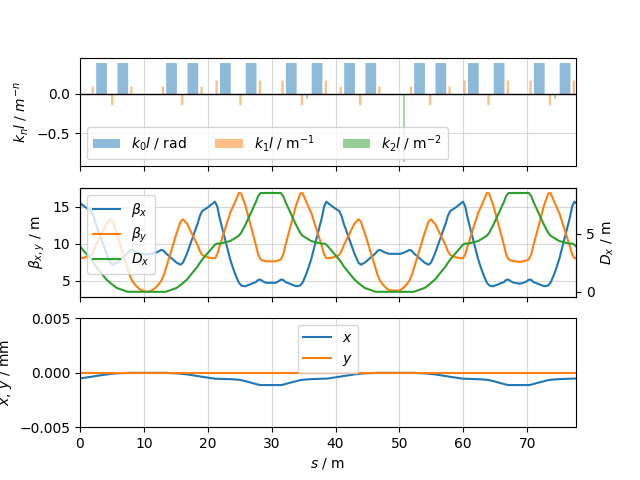

In [9]:
import xplt
plot = xplt.TwissPlot(tw, line=line)
plot.axis("x").set(ylim=(-5e-3, 5e-3));

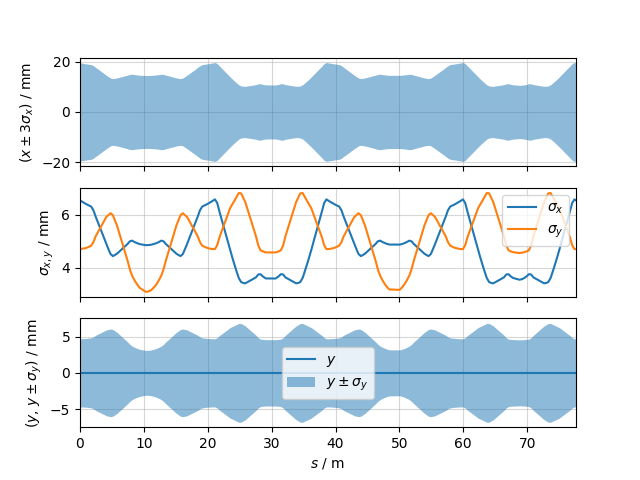

In [10]:
# Normalized emittance in m*rad
cv = tw.get_betatron_sigmas(nemitt_x=1e-6, nemitt_y=1e-6)

plot = xplt.TwissPlot((tw, cv), "envelope3_x, sigma, y + envelope_y")

In [11]:
import xdeps as xd

ap = xplt.util.apertures(line)
xd.Table(ap, index="s").to_pandas()

,s,min_x,max_x,min_y,max_y
0,0.0,-0.1,0.1,-0.1,0.1


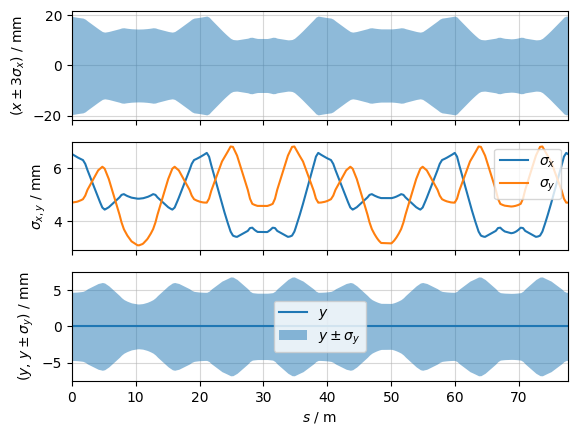

In [12]:
plot.plot_apertures(ap, lw=2, color="r")
plot.fig

### Define search region

In [13]:
# Mark septum position
x_septum = 3.5e-2

search_region = optics.closest_stable_unstable(line, num_turns=num_turns, xBoundary=x_septum)

# Inspect the narrowed-down search region
search_region

[np.float64(0.01916656494140625), np.float64(0.019167480468749998)]

### Find Separatrix

In [14]:
# Get coordinates of the particle at the separatrix
rec_separ = optics.record_separatrix(line, x_septum, search_region, num_turns=num_turns)

# Get normalized coordinates
nc_separ = tw.get_normalized_coordinates(rec_separ)

/home/aefstrat/miniforge3/lib/python3.12/site-packages/xtrack/twiss.py:3238: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],


### Polynomial fit for the separatrix at the septum

In [15]:
# Details after polynomial fit at the septum
fit_at_septum = optics.separatrix_at_septum(rec_separ, x_septum, num_turns=num_turns)

# Inspect the details after polynomial fit at the septum (dictionary)
fit_at_septum

{'slope': np.float64(0.02349659838431716),
 'px_at_septum': np.float64(0.002673840257941026),
 'closer_turn': np.int64(237),
 'poly_sep': array([0.0234966 , 0.00185146])}

In [16]:
# Inspect the measured slope of the separatrix at the septum
print(f'Slope at the septum = {fit_at_septum['slope']}')

Slope at the septum = 0.02349659838431716


In [17]:
px_septum = float(fit_at_septum['px_at_septum'])

# Inspect the point of intersection
print(f"Intersection Point = {(x_septum, px_septum)}")

Intersection Point = (0.035, 0.002673840257941026)


In [18]:
# Inspect the turn at which the particle was closer to the septum.
print(f'Turn closer to septum = {fit_at_septum['closer_turn']}')

Turn closer to septum = 237


In [19]:
poly_sep = fit_at_septum['poly_sep']

# Inspect the array of coefficients of the best first degree fit straight line.
print(f'Least square line coefficients = {poly_sep}')

Least square line coefficients = [0.0234966  0.00185146]


### Calculate boundary of the stable area

In [20]:
# Get coordinates of the particle at the stable triangle
rec_triang = optics.find_boundary_stable(line, search_region, num_turns=num_turns)

# Get corresponding normalized coordinates
nc_triang = tw.get_normalized_coordinates(rec_triang)

In [21]:
# Get a dictionary with sorted physical and normilized coordinates
sorted_triang = optics.sort_stable_boundary_coordinates(tbt_triang=rec_triang, nc_tbt_triang=nc_triang)

# Inspect dictionary with sorted physical and normilized coordinates
sorted_triang

{'x_triang': array([-0.02963188, -0.02971096, -0.02978951, ..., -0.02926512,
        -0.02934659, -0.02942755], shape=(2000,)),
 'px_triang': array([0.00070372, 0.00070068, 0.00069766, ..., 0.00071781, 0.00071468,
        0.00071157], shape=(2000,)),
 'x_norm_triang': array([-0.0075201 , -0.00754017, -0.0075601 , ..., -0.00742702,
        -0.0074477 , -0.00746824], shape=(2000,)),
 'px_norm_triang': array([-2.42395001e-05, -4.36872989e-05, -6.30135061e-05, ...,
         6.58691899e-05,  4.58641184e-05,  2.59809905e-05], shape=(2000,))}

### Find fixed points

In [22]:
# Get a dictionary with fixed points
fixed_points = optics.find_fixed_points(tbt_triang=rec_triang, nc_tbt_triang=nc_triang)

# Inspect dictionary
fixed_points

{'x_norm_fp': array([-0.00984593,  0.00637897,  0.00315983]),
 'px_norm_fp': array([-0.00235772, -0.00784828,  0.0093969 ]),
 'x_fp': array([-0.03879632,  0.02513447,  0.01245012]),
 'px_fp': array([ 0.00033104, -0.0025938 ,  0.00208667])}

### Plot

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


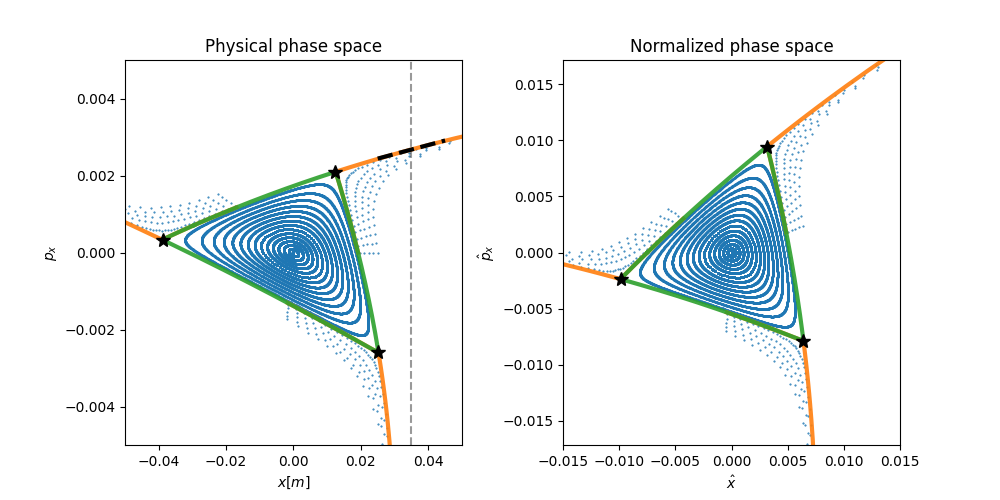

In [23]:
# Call a function to plot every calculated quantity in both physical and normalized phase space
optics.plot_phase_space(rec_part=rec, nc_part=nc, 
                        rec_sep=rec_separ, nc_sep=nc_separ, 
                        poly_sep=poly_sep, sorted_tr=sorted_triang, 
                        fixed_p=fixed_points, xBoundary=x_septum)

#### Compute area of the stable region

In [24]:
# Area of the stable regions (determinant of the matrix with the vertices)
stable_area = optics.stable_area(fixed_points)

### Summary of the computed quantities

In [25]:
print(f'intersection_point = {(x_septum, float(px_septum))}\n')
print(f'slope_at_septum = {"%.3e"%(fit_at_septum['slope'])}\n')
print(f'stable_area = {"%.3e"%(stable_area)}\n')
print(f'x_fp = {fixed_points['x_fp']}\n')
print(f'px_fp = {fixed_points['px_fp']}\n')
print(f'x_norm_fp = {fixed_points['x_norm_fp']}\n')
print(f'px_norm_fp = {fixed_points['px_norm_fp']}\n')

intersection_point = (0.035, 0.002673840257941026)

slope_at_septum = 2.350e-02

stable_area = 1.311e-04

x_fp = [-0.03879632  0.02513447  0.01245012]

px_fp = [ 0.00033104 -0.0025938   0.00208667]

x_norm_fp = [-0.00984593  0.00637897  0.00315983]

px_norm_fp = [-0.00235772 -0.00784828  0.0093969 ]



{'dpx_dx_at_septum': np.float64(0.02349659838431716),
 'px_at_septum': np.float64(0.002673840257941026),
 'stable_area': np.float64(0.00013106318454349512),
 'x_fp': array([-0.03879632,  0.02513447,  0.01245012]),
 'px_fp': array([-0.03879632,  0.02513447,  0.01245012]),
 'x_norm_fp': array([-0.00984593,  0.00637897,  0.00315983]),
 'px_norm_fp': array([-0.00984593,  0.00637897,  0.00315983])}

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


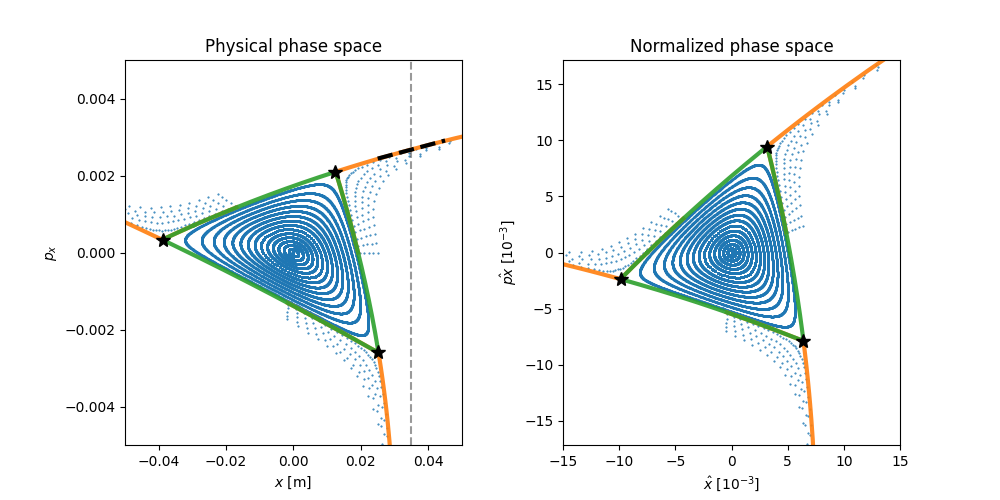

In [26]:
optics.characterize_phase_space_at_septum(line, x_gen=x_gen, 
                                          xBoundary=x_septum, num_turns=num_turns, plot=True)

### Inspect resonance sextupole

In [27]:
line['s8_028a_sxr']

# NOTE: If the resonance sextupole is switched off (line.vars['sr'] = 0)
# the particle trajectories are circles in normalised phase space.

View of Sextupole(k2=-3.3, k2s=0, length=0.26, _order=np.int64(5), inv_factorial_order=0.00833, knl=array([0., 0., 0., 0., 0., 0.]), ksl=array([0., 0., 0., 0., 0., 0.]), edge_entry_active=np.uint64(0), edge_exit_active=np.uint64(0), _sin_rot_s=-999, _cos_rot_s=-999, _shift_x=0, _shift_y=0, _shift_s=0, _internal_record_id=RecordIdentifier(buffer_id=np.int64(0), offset=np.int64(0)))